In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

C:\Users\makal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
def _normalize_img(img, label):
    # img = img / 255.
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="cifar10", split=['train', 'test'], as_supervised=True)
print(train_dataset)
# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [4]:
(img_train, label_train), (img_test, label_test) = tf.keras.datasets.cifar10.load_data()
img_train = img_train/255
img_test = img_test/255


In [5]:
# label_train = label_train.reshape(-1, )
print(label_train.shape)
classes = ['airplane', 'automobile','bird','cat','deer','dog', 'frog', 'horse', 'ship', 'truck']

(50000, 1)


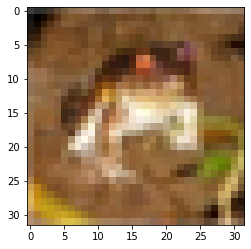

In [6]:
plt.imshow(img_train[0])
plt.show()

In [7]:
def generate_triplets(images, labels):
    set_len = len(labels)
    triplets = []
    for index, value in enumerate(images):
        random_index_p = np.random.randint(0, set_len)
        random_index_n = np.random.randint(0, set_len)
        while labels[index] != labels[random_index_p]:
            random_index_p = np.random.randint(0, set_len)
        while labels[index] == labels[random_index_n]:
            random_index_n = np.random.randint(0, set_len)
        triplets.append((value, images[random_index_p], images[random_index_n]))
    return triplets
     
tripets = generate_triplets(img_train, label_train)


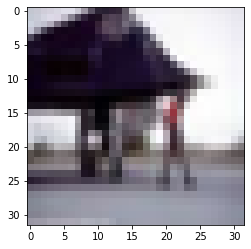

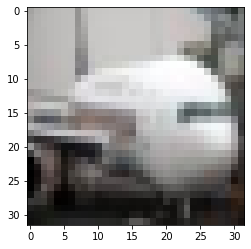

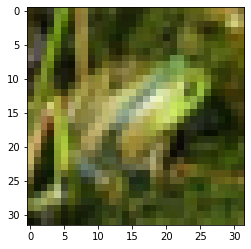

In [8]:
test = tripets[np.random.randint(0, len(label_train))]
plt.imshow(test[0])
plt.show()
plt.imshow(test[1])
plt.show()
plt.imshow(test[2])
plt.show()

In [9]:
conv_NN = tf.keras.models.Sequential()
conv_NN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
conv_NN.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
conv_NN.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
# conv_NN.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
conv_NN.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN.add(tf.keras.layers.Flatten())
# conv_NN.add(tf.keras.layers.Dense(34, activation='relu'))
# conv_NN.add(tf.keras.layers.Dense(10, activation='softmax'))
conv_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          3

In [10]:
# Compile the model
conv_NN.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())


In [11]:
conv_NN.fit(
    train_dataset,
    epochs=5)

Epoch 1/5
1563/1563 [==============================] - 41s 24ms/step - loss: 0.3231
Epoch 2/5
1563/1563 [==============================] - 38s 24ms/step - loss: 0.2423
Epoch 3/5
1563/1563 [==============================] - 39s 25ms/step - loss: 0.1901
Epoch 4/5
1563/1563 [==============================] - 38s 24ms/step - loss: 0.1659
Epoch 5/5
1563/1563 [==============================] - 38s 24ms/step - loss: 0.1517


In [12]:
conv_NN.build()
conv_NN.trainable = False
conv_NN_F = tf.keras.Sequential([conv_NN, tf.keras.layers.Dense(34, activation='relu'),tf.keras.layers.Dense(10, activation='softmax')])
# conv_NN.add(tf.keras.layers.Flatten())
# conv_NN.add(tf.keras.layers.Dense(34, activation='relu'))
# conv_NN.add(tf.keras.layers.Dense(10, activation='softmax'))
conv_NN_F.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                93248     
                                                                 
 dense (Dense)               (None, 34)                2210      
                                                                 
 dense_1 (Dense)             (None, 10)                350       
                                                                 
Total params: 95,808
Trainable params: 2,560
Non-trainable params: 93,248
_________________________________________________________________


In [13]:
conv_NN_F.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
conv_NN_F.fit(img_train, label_train, epochs=6)

Epoch 1/6
1563/1563 [==============================] - 11s 6ms/step - loss: 1.7309 - accuracy: 0.4163
Epoch 2/6
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4365 - accuracy: 0.4683
Epoch 3/6
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3947 - accuracy: 0.4797
Epoch 4/6
1563/1563 [==============================] - 9s 5ms/step - loss: 1.3765 - accuracy: 0.4879
Epoch 5/6
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3651 - accuracy: 0.4888
Epoch 6/6
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3578 - accuracy: 0.4945


In [14]:
conv_NN2 = tf.keras.models.Sequential()
conv_NN2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
conv_NN2.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
conv_NN2.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
# conv_NN.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
conv_NN2.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN2.add(tf.keras.layers.Flatten())
# conv_NN.add(tf.keras.layers.Dense(34, activation='relu'))
# conv_NN.add(tf.keras.layers.Dense(10, activation='softmax'))
# conv_NN2.add(tf.keras.layers.Flatten())
conv_NN2.add(tf.keras.layers.Dense(34, activation='relu'))
conv_NN2.add(tf.keras.layers.Dense(10, activation='softmax'))
conv_NN2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 64)         

In [15]:
conv_NN2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
conv_NN2.fit(img_train, label_train, epochs=6)

Epoch 1/6
1563/1563 [==============================] - 38s 23ms/step - loss: 1.6262 - accuracy: 0.3973
Epoch 2/6
1563/1563 [==============================] - 33s 21ms/step - loss: 1.2466 - accuracy: 0.5546
Epoch 3/6
1563/1563 [==============================] - 33s 21ms/step - loss: 1.1040 - accuracy: 0.6084
Epoch 4/6
1563/1563 [==============================] - 32s 21ms/step - loss: 1.0052 - accuracy: 0.6481
Epoch 5/6
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9279 - accuracy: 0.6753
Epoch 6/6
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8747 - accuracy: 0.6940


In [16]:
conv_NN_3 = tf.keras.models.Sequential()
conv_NN_3.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
conv_NN_3.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN_3.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
conv_NN_3.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN_3.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
# conv_NN.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN_3.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
conv_NN_3.add(tf.keras.layers.MaxPool2D((2, 2)))

conv_NN_3.add(tf.keras.layers.Flatten())
# conv_NN.add(tf.keras.layers.Dense(34, activation='relu'))
# conv_NN.add(tf.keras.layers.Dense(10, activation='softmax'))
conv_NN_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 64)         

In [17]:
# Compile the model
conv_NN_3.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [18]:
conv_NN_3.fit(
    train_dataset,
    epochs=5)

Epoch 1/5
1563/1563 [==============================] - 36s 22ms/step - loss: 0.3551
Epoch 2/5
1563/1563 [==============================] - 37s 24ms/step - loss: 0.2368
Epoch 3/5
1563/1563 [==============================] - 36s 23ms/step - loss: 0.1967
Epoch 4/5
1563/1563 [==============================] - 39s 25ms/step - loss: 0.1769
Epoch 5/5
1563/1563 [==============================] - 36s 23ms/step - loss: 0.1581


In [19]:
conv_NN_NF = tf.keras.Sequential([conv_NN_3, tf.keras.layers.Dense(34, activation='relu'),tf.keras.layers.Dense(10, activation='softmax')])
conv_NN_NF.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64)                93248     
                                                                 
 dense_4 (Dense)             (None, 34)                2210      
                                                                 
 dense_5 (Dense)             (None, 10)                350       
                                                                 
Total params: 95,808
Trainable params: 95,808
Non-trainable params: 0
_________________________________________________________________


In [20]:
conv_NN_NF.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
conv_NN_NF.fit(img_train, label_train, epochs=6)

Epoch 1/6
1563/1563 [==============================] - 36s 21ms/step - loss: 1.5029 - accuracy: 0.4643
Epoch 2/6
1563/1563 [==============================] - 34s 22ms/step - loss: 1.1720 - accuracy: 0.5744
Epoch 3/6
1563/1563 [==============================] - 33s 21ms/step - loss: 1.0619 - accuracy: 0.6183
Epoch 4/6
1563/1563 [==============================] - 35s 22ms/step - loss: 0.9850 - accuracy: 0.6491
Epoch 5/6
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9249 - accuracy: 0.6698
Epoch 6/6
1563/1563 [==============================] - 35s 22ms/step - loss: 0.8708 - accuracy: 0.6921


In [21]:
conv_NN2.evaluate(img_test, label_test)
conv_NN_F.evaluate(img_test, label_test)
conv_NN_NF.evaluate(img_test, label_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.9515 - accuracy: 0.6655


[0.9515026211738586, 0.6654999852180481]